# Let's detect some surfaces!

In this project our task is to detect the floor surface the robots are moving on. Data is collected from Inertial Measurement Units (IMU). This is from the Kaggle competition at https://www.kaggle.com/c/career-con-2019 The objective is to help robots navigate by detecting the surface they are moving on. We have access to orientation, angular velocity and linear acceleration.

# What's new here:
    - I add High Pass and Low Pass filters to filter the IMU data.
    - I use group_id for better cross validation.
    - I make the random forest not overfit to data intentionally by limiting it's depth/impurity stuff.
    - I use feature elimination to remove most of the features not needed.

In [1]:
import os
import time
import numpy as np
import pandas as pd
from seaborn import countplot,lineplot, barplot
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix

from random import shuffle

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

%matplotlib inline

In [2]:
train = pd.read_csv('../input/X_train.csv')
test = pd.read_csv('../input/X_test.csv')
target = pd.read_csv('../input/y_train.csv')
ss = pd.read_csv('../input/sample_submission.csv')

In [3]:
train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [4]:
train.shape, test.shape

((487680, 13), (488448, 13))

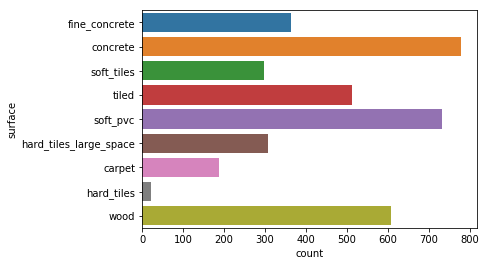

In [5]:
countplot(y='surface', data=target)
plt.show()

In [6]:
train.shape[0]/128, test.shape[0]/128

(3810.0, 3816.0)

We have 3810 train series, and 3816 test series.

In [7]:
target.groupby('surface')['group_id'].nunique()

surface
carpet                     4
concrete                  15
fine_concrete              7
hard_tiles                 1
hard_tiles_large_space     5
soft_pvc                  14
soft_tiles                 6
tiled                      9
wood                      12
Name: group_id, dtype: int64

This is a multi-class classification problem. It's supervised and has imbalanced classes.
Each measurement has 128 data points taken over time for each sensor. The identifier for each measurement is series_id. Then each measurement is repeated on the same surface multiple times which is identified by group_id.

The chart above shows the number of group_id values for each surface in training data. 

## Feature Engineering

### Let's applyour high pass and low pass filters. 
Why do we need this? 

The data is noisy as you'll see below. My guess is that most of the important information should be in linear acceleration, because that's what measuring the movements which the robot feels from different surfaces.
We don't usually care about low freqeuncy signal in linear acceleration. That's just the driver applying acceleration. Driving on a different surface should not add a bias to linear acceleration so let's remove low frequencies. But the high frequency components should give us what we want. 

For velocity and orientation, I will apply low pass filter to remove noise. We will be using different critical frequncy for orientation and velocity.

Let's see how this goes and if my hunch is justified.

In [8]:
# columns to use for filtering
cols = train.columns[3:]
cols

Index(['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W',
       'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z',
       'linear_acceleration_X', 'linear_acceleration_Y',
       'linear_acceleration_Z'],
      dtype='object')

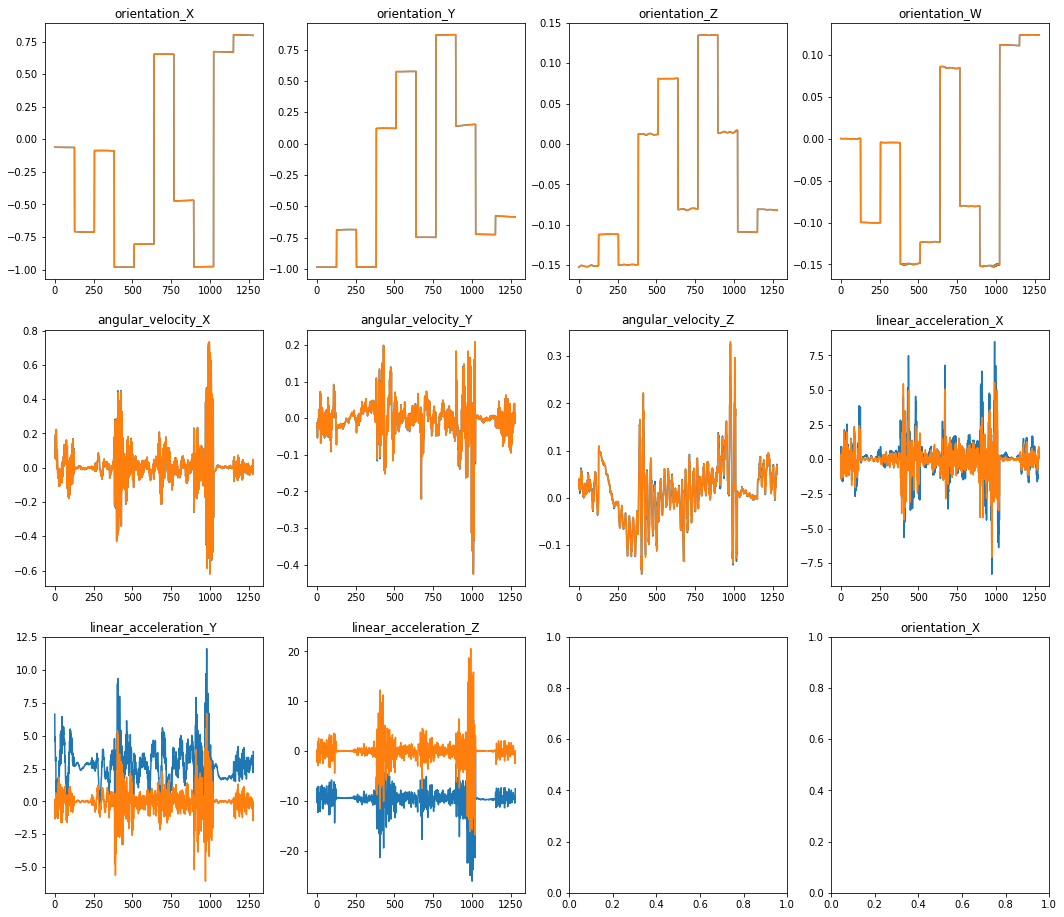

In [9]:
# HP/LP Filter
from scipy import signal

def HP_filter(sig, critical_freq=0.05):
    b, a = signal.butter(4, critical_freq, analog=False, btype='highpass')
    out = signal.filtfilt(b, a, sig)
    sig[:] = out
    return sig

def LP_filter(sig, critical_freq=0.2):
    #b, a = signal.butter(4, critical_freq, analog=False, btype='highpass')
    b, a = signal.butter(4, critical_freq, analog=False, btype='lowpass')
    out = signal.filtfilt(b, a, sig)
    sig[:] = out
    return sig


temp_sid_sample = 0
HPF_enabled = True
if HPF_enabled:
    fig, ax = plt.subplots(3, 4, figsize=(18, 16) )
    
    temp_sid_sample = [train.series_id.sample(1)+ii for ii in np.arange(10)]
    
    i=0
    for col in cols:
        ax[int(i/4), int(i%4)].plot( train.loc[ train.series_id.isin(temp_sid_sample), col ].tolist() )
        if col.startswith('orient'):
            train[col+'_f'] = train.groupby(['series_id'])[col].apply(LP_filter)
            test[col+'_f']  = test.groupby(['series_id'])[col].apply(LP_filter)
        elif col.startswith('angular'):
            train[col+'_f'] = train.groupby(['series_id'])[col].apply(LP_filter, 0.9)
            test[col+'_f']  = test.groupby(['series_id'])[col].apply(LP_filter, 0.9)
        else:
            train[col+'_f'] = train.groupby(['series_id'])[col].apply(HP_filter)
            test[col+'_f']  = test.groupby(['series_id'])[col].apply(HP_filter)

        ax[int(i/4), int(i%4)].plot( np.array(train.loc[ train.series_id.isin(temp_sid_sample), col+'_f' ]) )
        ax[int(i/4), int(i%4)].set_title(col)
        i+=1
    plt.title(cols[0])

Blue is the original data. 
Orange is filtered data. 

Orientation: 
    - filtered data is similar to unfiltered. Probably some very high frequency points are removed.
    
angular velocity:
    - filtered data mostly similar to unfiltered. Some high frequency points removed.
    
linear acceleration:
    - we removed bias from data. Only kept the high frequency response. Here, I wanted the information from driving pattern of the driver to be eliminated and it seems that it worked. 

##### I'm leaving this one out. I think this would be great for detecting frequnecy shift on different surfaces. I might come back to this later.
##### FFT plots
fig, ax = plt.subplots(3, 4, figsize=(18, 16) )
i=0
for temp in ['orientation', 'angular', 'linear']:
    cols = train.columns[train.columns.str.startswith(temp)]
    cols = cols[ ~cols.str.endswith('_f')  ]
    j=0
    for col in cols:
        y    = np.array(train[col])
        Y    = np.fft.fft(y)
        freq = np.fft.fftfreq(len(y), 1)
        ps   = np.abs(Y)**2
        
        y2    = LP_filter(y, 0.1)        
        Y2    = np.fft.fft(y2)
        freq2 = np.fft.fftfreq(len(y2), 1)
        ps2   = np.abs(Y2)**2
        
        ax[i,j].plot(freq, np.abs(Y))
        ax[i,j].plot(freq2, np.abs(Y2))
        ax[i,j].set_title(col)
        #ax[i,j].set_yscale('log')
        j+=1
    i+=1

Let's use absolute values only

In [10]:
train[train.columns[3:]] = train[train.columns[3:]].abs()
test[test.columns[3:]]   = test[test.columns[3:]].abs()

Let's pick the filtered columns only. 

In [11]:
# Define is we want to pick filtered values or unfiltered. Remove "_f" if unfiltered is desired.
# Orientation:filtered, angular:filtered, linear:filtered
feature_cols = ['orientation_X_f', 'orientation_Y_f', 'orientation_Z_f', 'orientation_W_f',
       'angular_velocity_X_f', 'angular_velocity_Y_f', 'angular_velocity_Z_f',
       'linear_acceleration_X_f', 'linear_acceleration_Y_f', 'linear_acceleration_Z_f']

In [12]:
all_cols = ['row_id', 'series_id', 'measurement_number'] + feature_cols
if HPF_enabled==False:
    all_cols = train.columns
train = train[all_cols]
test  = test[all_cols]
train.shape, test.shape, train.columns

((487680, 13),
 (488448, 13),
 Index(['row_id', 'series_id', 'measurement_number', 'orientation_X_f',
        'orientation_Y_f', 'orientation_Z_f', 'orientation_W_f',
        'angular_velocity_X_f', 'angular_velocity_Y_f', 'angular_velocity_Z_f',
        'linear_acceleration_X_f', 'linear_acceleration_Y_f',
        'linear_acceleration_Z_f'],
       dtype='object'))

Let's create new features by taking mean, abs, std, etc.
This part is taken from other notebooks. See below. 

In [13]:
# https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def fe(actual, feature_cols):
    new = pd.DataFrame()
    if 'angular_velocity_X' in feature_cols:
        actual['total_angular_velocity'] = (actual['angular_velocity_X'] ** 2 + actual['angular_velocity_Y'] ** 2 + actual['angular_velocity_Z'] ** 2) ** 0.5
    if 'angular_velocity_X_f' in feature_cols:
        actual['total_angular_velocity'] = (actual['angular_velocity_X_f'] ** 2 + actual['angular_velocity_Y_f'] ** 2 + actual['angular_velocity_Z_f'] ** 2) ** 0.5

    if 'linear_acceleration_X' in feature_cols:
        actual['total_linear_acceleration'] = (actual['linear_acceleration_X'] ** 2 + actual['linear_acceleration_Y'] ** 2 + actual['linear_acceleration_Z'] ** 2) ** 0.5
    if 'linear_acceleration_X_f' in feature_cols:
        actual['total_linear_acceleration'] = (actual['linear_acceleration_X_f'] ** 2 + actual['linear_acceleration_Y_f'] ** 2 + actual['linear_acceleration_Z_f'] ** 2) ** 0.5


    #actual['acc_vs_vel'] = actual['total_linear_acceleration'] / actual['total_angular_velocity']
    
    if 'orientation_X' in feature_cols:
        x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    if 'orientation_X_f' in feature_cols:        
        x, y, z, w = actual['orientation_X_f'].tolist(), actual['orientation_Y_f'].tolist(), actual['orientation_Z_f'].tolist(), actual['orientation_W_f'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    
    actual['total_angle'] = (actual['euler_x'] ** 2 + actual['euler_y'] ** 2 + actual['euler_z'] ** 2) ** 5
    
    actual['angle_vs_acc'] = actual['total_angle'] / actual['total_linear_acceleration']
    actual['angle_vs_vel'] = actual['total_angle'] / actual['total_angular_velocity']
    
    def f1(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    def f2(x):
        return np.mean(np.abs(np.diff(x)))
    
    for col in actual.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        new[col + '_mean'] = actual.groupby(['series_id'])[col].mean()
        new[col + '_min'] = actual.groupby(['series_id'])[col].min()
        new[col + '_max'] = actual.groupby(['series_id'])[col].max()
        new[col + '_std'] = actual.groupby(['series_id'])[col].std()
        #new[col + '_max_to_min'] = new[col + '_max'] / new[col + '_min']
        
        # Change. 1st order.
        new[col + '_mean_abs_change'] = actual.groupby('series_id')[col].apply(f2)
        
        # Change of Change. 2nd order.
        new[col + '_mean_change_of_abs_change'] = actual.groupby('series_id')[col].apply(f1)
        
        new[col + '_abs_max'] = actual.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        new[col + '_abs_min'] = actual.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))

    return new

In [14]:
#%%time
train_stats = fe(train, train.columns).copy()
test_stats  = fe(test, test.columns).copy()
train_stats.head()

CPU times: user 3min 45s, sys: 2.29 s, total: 3min 47s
Wall time: 4min 6s


In [16]:
train_stats.shape, test_stats.shape

((3810, 144), (3816, 144))

In [17]:
le = LabelEncoder()
target['surface'] = le.fit_transform(target['surface'])

In [18]:
train_stats.fillna(0, inplace = True)
test_stats.fillna(0, inplace = True)

In [19]:
train_stats.replace(-np.inf, 0, inplace = True)
train_stats.replace(np.inf, 0, inplace = True)
test_stats.replace(-np.inf, 0, inplace = True)
test_stats.replace(np.inf, 0, inplace = True)

Merging train and taget data into a single dataframe. 

In [20]:
df = pd.merge(train_stats, target, how='inner', on='series_id')

## Random Forest

First we need to come up with a train/test split strategy. Most kernels I've seen are using Stratified KFold over surface to ensure an even distribution of data over classes. While this is smart and yields very good test score, it does not generalize well. From my tests on this dataset, if we split the data by group_id, the prediction becomes much harder.
Since we want this model to generalize and it's fair to assume that group_id will be different in future data (unseen data), it's a good idea to split on group_id and take the hard approach. 

Why not use KFold on group_id? Here's we are trying to balance by surface and group_id. KFold only balances on one of them. 

In [21]:
# Split train/test data by group_id so that train and test don't have overlapping group_id.
# For each surface, randomly sample 20% of group_id values and assign them to test samples.
# The rest goes to train samples. For surface=3, we have 1 group_id. So use 20% of series_id to split.
def sample_split_by_groupID(df, test_size=0.2, seed=None):
    if seed is not None:
        np.random.seed(seed)
    test_gid = np.array([])
    for k, G in df.groupby('surface'):
        if k==3:   # Skip 3 since it has only 1 group.
            continue
        ch = np.random.choice(G['group_id'].unique(), int(max(1, test_size*G['group_id'].nunique())), replace=False )
        test_gid=np.append(test_gid, ch)

    # series_id chosen from surface=3
    test_sid_s3 = np.random.choice( df[df.surface==3].series_id.unique(), int(max(1, 0.2*df[df.surface==3].series_id.nunique())) )
    X_test  = df[df.group_id.isin(test_gid) | df.series_id.isin(test_sid_s3) ]
    X_train = df[~df.series_id.isin(X_test.series_id)]

    #print('Train size: ', X_train.shape, '\tTest size: ', X_test.shape)
    if (pd.merge(X_train, X_test, how='inner', on='series_id').shape[0] == 0):
        pass
    else:
        raise(ValueError('Train and Test have overlapping series_id. This was not intended by design.'))
    return X_train, X_test

Now that we have a split strategy, we can focuse on our Random Forest algorithm. Let's do a quick RF and see where we are.

In [22]:
clf =  RandomForestClassifier(n_estimators = 200, n_jobs = -1, class_weight="balanced_subsample")
feature_cols = df.columns.drop(['group_id', 'series_id', 'surface'])
clf.fit(df[feature_cols], df['surface'])
clf.score(df[feature_cols], df['surface'])

1.0

That's no good! We have a perfect training score, which means we are overfitting to training data. We will need to eliminate this by using better features, eliminating most of unnecessary features and limiting the random forest depth.  

In [23]:
### Random Forest
# y_pred and y_test are only for the last X_test. 
# setting max_depth to low values.
# return score or f_score if needed.
def run_RandomForest_CV(df, test_stats, cv=5, test_size=0.2, verbose=True, seed=None):
    preds_final  = np.zeros((cv, test_stats.shape[0], df.surface.nunique()))
    y_pred = []
    y_test = []
    score = []
    f_score = []
    clf =  RandomForestClassifier(n_estimators = 200, n_jobs = -1, class_weight="balanced_subsample", max_depth=10)

    for i in np.arange(cv):
        X_train, X_test = sample_split_by_groupID(df, test_size, seed)
        if seed is not None:
            seed += 1

        if verbose:
            print('-'*20, i, '-'*20, X_train.shape, X_test.shape)
            
        feature_cols = X_train.columns.drop(['group_id', 'series_id', 'surface'])

        clf.fit(X_train[feature_cols], X_train['surface'])
        
        y_pred = clf.predict(X_test[feature_cols])
        y_test = X_test['surface']
        preds_final += clf.predict_proba(test_stats[feature_cols]) / cv

        score = score + [clf.score(X_test[feature_cols], X_test['surface'])]
        if verbose:
            print('Train score ', clf.score(X_train[feature_cols], X_train['surface']))
            print('Test score ', clf.score(X_test[feature_cols], X_test['surface']))

        importances = clf.feature_importances_
        FI = pd.DataFrame([x for x in zip(clf.feature_importances_, feature_cols)], columns=['FI', 'feature'])
        if verbose:
            FI.sort_values(by='FI', ascending=False).iloc[0:min(30, len(FI))].plot.barh(x='feature', y='FI', figsize=(5,10))
            plt.show()
        
        #pdb.set_trace()
        [_,_, f_x, _] = precision_recall_fscore_support(X_test['surface'].values, y_pred, average='weighted')
        f_score = f_score + [f_x]
    if verbose:
        print('Test Accuracy', [ '%.2f' % elem for elem in score ] )
        print('F-1 score', [ '%.2f' % elem for elem in f_score ] )
        print('Min Accuracy/F-1:', '%.2f' % min(score), '%.2f' % min(f_score))
    
    return clf, FI, y_test, y_pred, score  #, y_pred, y_test, val_score

-------------------- 0 -------------------- (3046, 147) (764, 147)
Train score  0.975705843729
Test score  0.501308900524


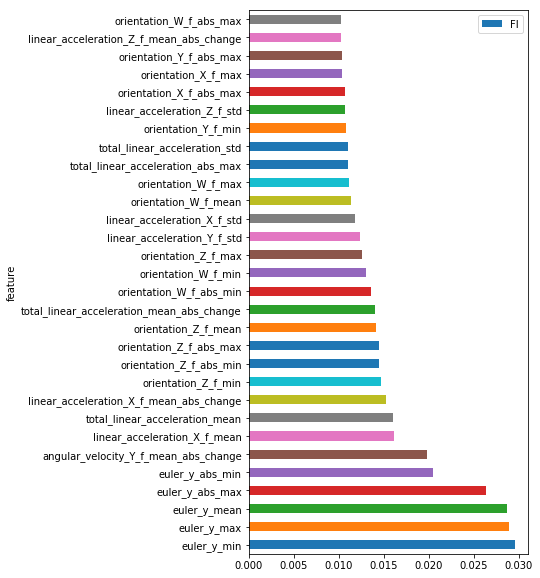

-------------------- 1 -------------------- (3273, 147) (537, 147)
Train score  0.985029025359
Test score  0.463687150838


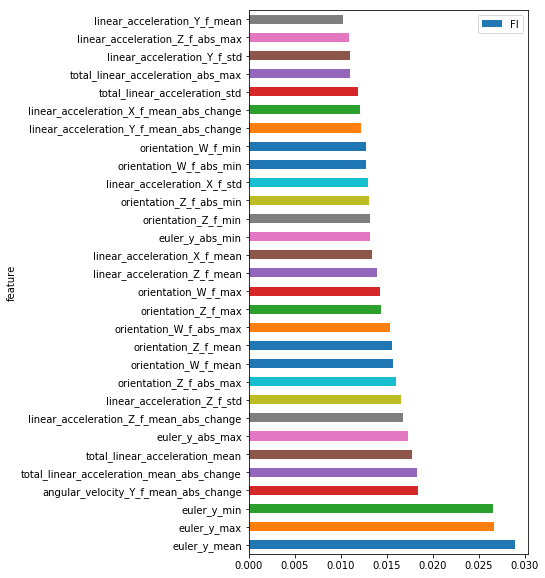

-------------------- 2 -------------------- (3123, 147) (687, 147)
Train score  0.979186679475
Test score  0.617176128093


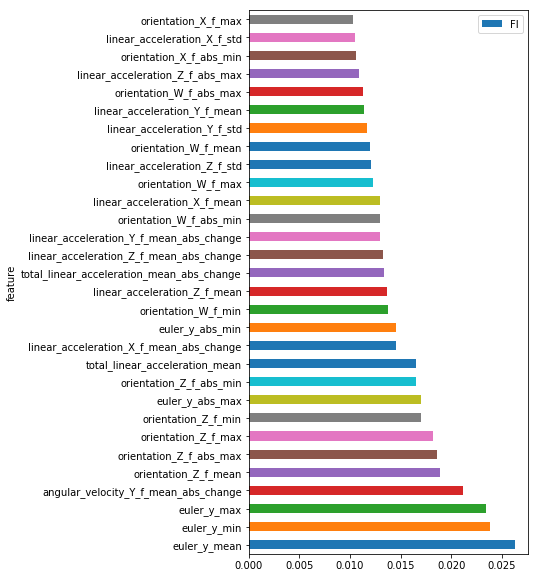

-------------------- 3 -------------------- (3196, 147) (614, 147)
Train score  0.979036295369
Test score  0.442996742671


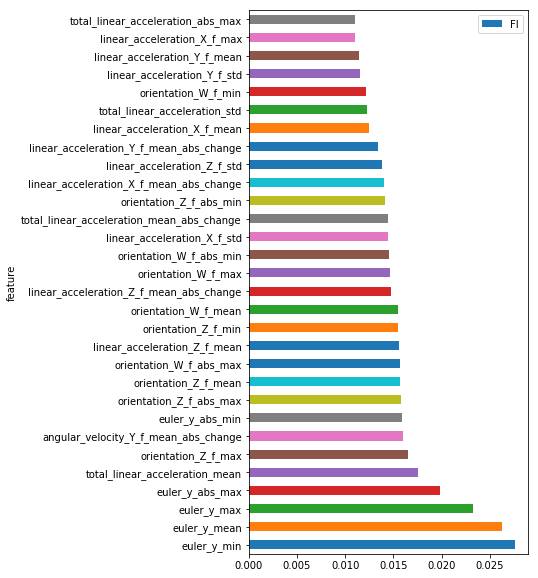

-------------------- 4 -------------------- (3168, 147) (642, 147)
Train score  0.972222222222
Test score  0.5


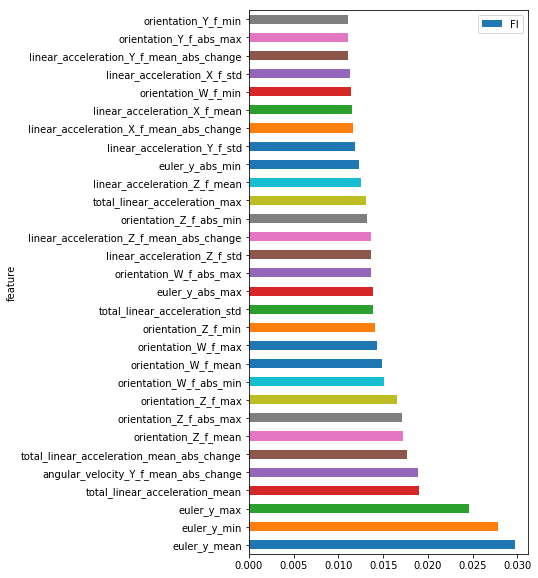

Test Accuracy ['0.50', '0.46', '0.62', '0.44', '0.50']
F-1 score ['0.45', '0.42', '0.58', '0.40', '0.48']
Min Accuracy/F-1: 0.44 0.40


In [24]:
clf, FI, y_test, y_pred, score = run_RandomForest_CV(df, test_stats, cv=5)

Ok, so we were able to lower training accuracy a bit by limiting max_depth. 
Test accuracy is low because it contains group_id which is not in training. 

The fact that orientation is among the top important features is a bit weird for me. But maybe that's the data. I would have discussed this more in detail with customers to see if it makes sense. 

In [25]:
# https://www.kaggle.com/artgor/where-do-the-robots-drive
import itertools

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

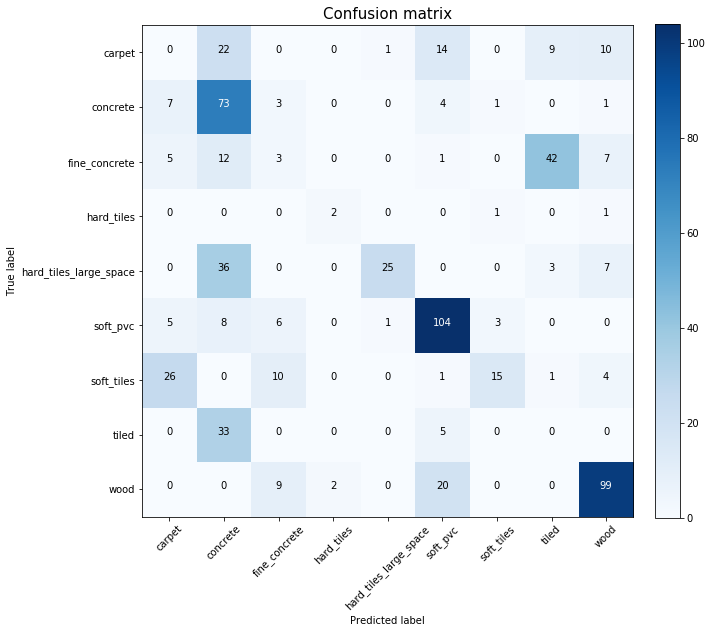

In [26]:
# test data
plot_confusion_matrix(y_test, y_pred, le.inverse_transform(clf.classes_))

Let's see what we learned. Depending on seed, this data might be different.
But it shows that some features can predict some classes much better.

Classes with good score:

    soft_pvc, soft_tiles, tiled, wood

Classes with ok score:
    
    concrete

Classes with terrible score:
    
    carpet, fine_concrete, hard_tiles, hard_tiles_large_space
    

# Feature Elimination

Let's remove features one by one and see if the test score improves. 
If dropping a feature does not degrade the score, then remove it. 

In [27]:
# Goes through all_cols items one by one. Drops item from features. Runs RF CV. 
# Takes the score as minimum score returned from CV.
#
def feature_elimination(all_cols, cv=5, seed=65789):
    select_cols = list(all_cols)
    val_score_base=0.0
    RFE_df = pd.DataFrame(columns=['Column', 'Val_Score', 'Dropped'])

    _, _, _, _, score = run_RandomForest_CV(df[select_cols+['group_id', 'series_id', 'surface']], test_stats, cv=cv, test_size=0.3, verbose=False, seed=seed)
    val_score_base = min(score)
    print('Base score:', val_score_base)
    print('Column'.ljust(52) +'\tMin_score\tAvg Score\tDropped\tfeatures')

    for col in all_cols:
        select_cols.remove(col)
        dropped = True
        _, _, _, _, score = run_RandomForest_CV(df[select_cols+['group_id', 'series_id', 'surface']], test_stats, cv=cv, test_size=0.3, verbose=False, seed=seed)
        val_score = min(score)
        if val_score_base>val_score * 1.02:
            # We could not afford to drop this columns since val_score dropped bad.
            select_cols.append(col)
            dropped = False
        # Keep the best score as base
        val_score_base = max(val_score, val_score_base)

        print(col.ljust(52)+ '\t'+"{0:.2f}".format(val_score)+"\t\t{0:.2f}".format(np.average(score))+ '\t\t'+str(dropped)+'\t'+str(len(select_cols)) )
        RFE_df = RFE_df.append( {'Column': col, 'Val_Score':val_score, 'Dropped':dropped} , ignore_index=True)
    return select_cols, RFE_df

In [28]:
select_cols = df.columns.drop(['group_id', 'series_id', 'surface']).tolist()

In [57]:
from random import shuffle
shuffle(select_cols)
select_cols, RFE_df = feature_elimination(select_cols, cv=5, seed=24876)

Base score: 0.376899696049
Column                                              	Min_score	Avg Score	Dropped	features
euler_x_mean                                        	0.38		0.45		True	75
total_linear_acceleration_mean_change_of_abs_change 	0.37		0.46		False	75
euler_y_abs_max                                     	0.37		0.44		False	75
total_linear_acceleration_min                       	0.37		0.45		False	75
angular_velocity_Z_f_mean_abs_change                	0.36		0.45		False	75
orientation_W_f_max                                 	0.38		0.46		True	74
angle_vs_vel_max                                    	0.38		0.46		True	73
euler_y_min                                         	0.40		0.48		True	72
angular_velocity_Y_f_std                            	0.40		0.47		True	71
angular_velocity_Y_f_abs_max                        	0.38		0.48		False	71
angular_velocity_X_f_abs_min                        	0.37		0.47		False	71
linear_acceleration_Y_f_max                         	0.38		0.47		False	71


Let's repeat feature elimination again.  

In [ ]:
from random import shuffle
shuffle(select_cols)
select_cols, RFE_df = feature_elimination(select_cols, cv=5, seed=65789)

I used a specific seed so the same set of samples are compared for every feature.
Every time we run the above code, it's better to use a different seed. 

So we started with 96 features and base score of 0.37.
We ended up with 28 features and score of 0.39. We improved the algo. Note that this was done for a specific seed. If we randomize the seed, it will behave different.

In [58]:
# Lets see which features are remaining.
select_cols

['total_linear_acceleration_mean_change_of_abs_change',
 'euler_y_abs_max',
 'total_linear_acceleration_min',
 'angular_velocity_Z_f_mean_abs_change',
 'angular_velocity_Y_f_abs_max',
 'angular_velocity_X_f_abs_min',
 'linear_acceleration_Y_f_max',
 'total_angular_velocity_abs_max',
 'total_angle_mean',
 'euler_x_abs_max',
 'linear_acceleration_Z_f_abs_min',
 'angular_velocity_Z_f_abs_max',
 'euler_y_mean_abs_change',
 'orientation_X_f_mean',
 'linear_acceleration_Z_f_mean',
 'angle_vs_vel_mean_abs_change',
 'euler_x_std',
 'angular_velocity_Z_f_abs_min',
 'angular_velocity_Y_f_min',
 'linear_acceleration_Z_f_mean_change_of_abs_change',
 'linear_acceleration_X_f_mean_abs_change',
 'angle_vs_vel_std',
 'orientation_X_f_mean_abs_change',
 'angle_vs_vel_mean_change_of_abs_change',
 'linear_acceleration_Z_f_min',
 'orientation_W_f_abs_max',
 'linear_acceleration_Y_f_min',
 'linear_acceleration_X_f_min',
 'total_angle_std',
 'total_linear_acceleration_mean_abs_change',
 'linear_acceleration

-------------------- 0 -------------------- (3220, 50) (590, 50)
Train score  0.959316770186
Test score  0.740677966102


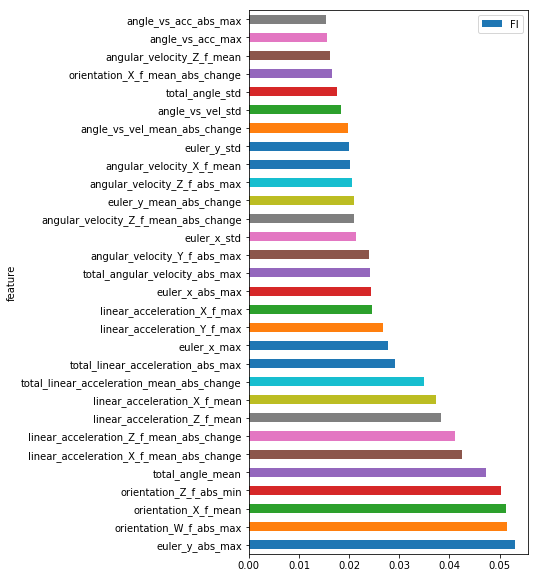

-------------------- 1 -------------------- (3191, 50) (619, 50)
Train score  0.954559699154
Test score  0.634894991922


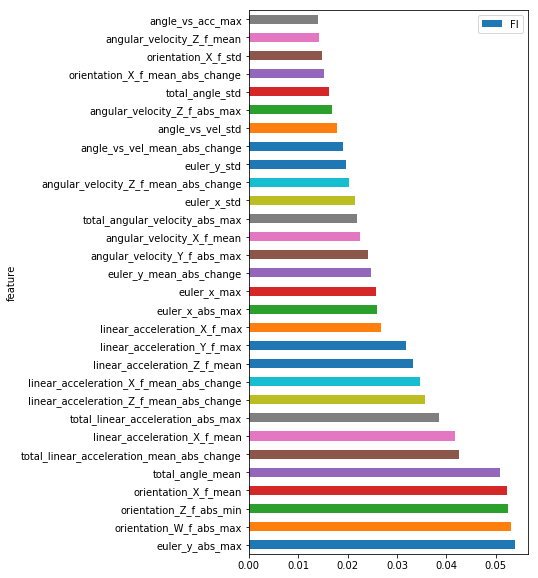

-------------------- 2 -------------------- (3161, 50) (649, 50)
Train score  0.972793419804
Test score  0.411402157165


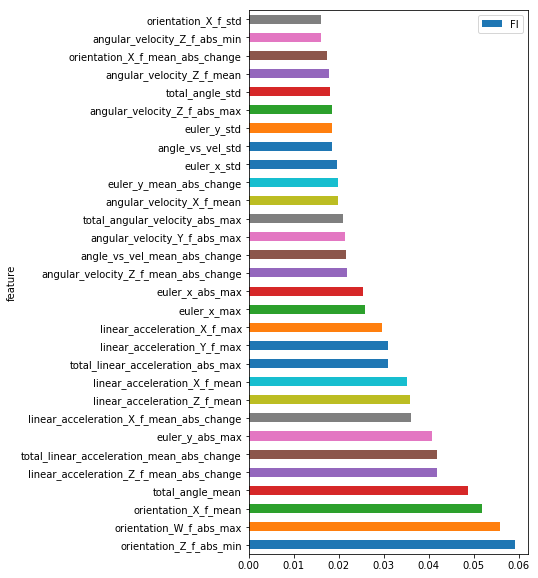

/Users/yasinkhatami/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-------------------- 3 -------------------- (3232, 50) (578, 50)
Train score  0.943997524752
Test score  0.544982698962


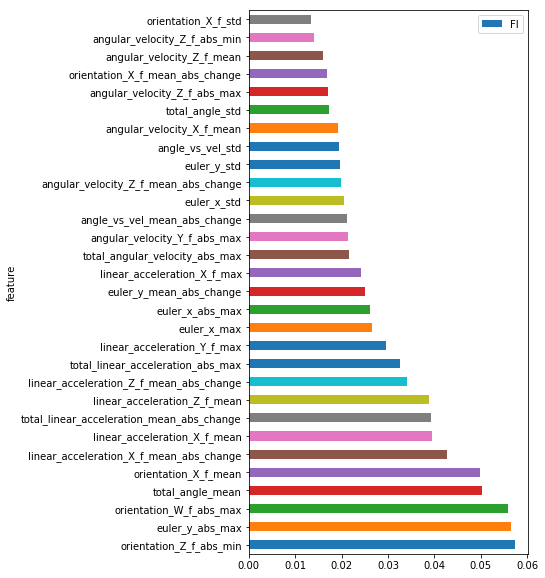

-------------------- 4 -------------------- (3231, 50) (579, 50)
Train score  0.963478799133
Test score  0.597582037997


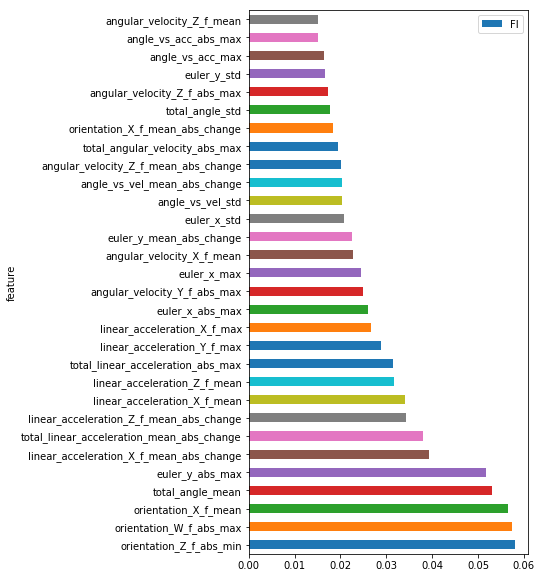

-------------------- 5 -------------------- (3205, 50) (605, 50)
Train score  0.95631825273
Test score  0.60826446281


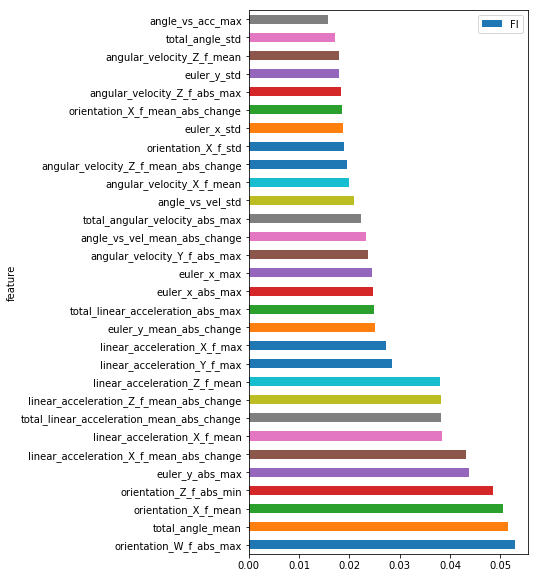

/Users/yasinkhatami/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-------------------- 6 -------------------- (3168, 50) (642, 50)
Train score  0.964330808081
Test score  0.595015576324


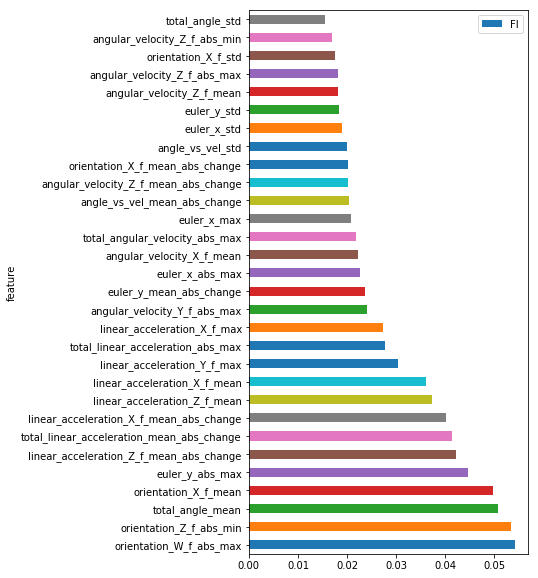

-------------------- 7 -------------------- (3134, 50) (676, 50)
Train score  0.963943841736
Test score  0.569526627219


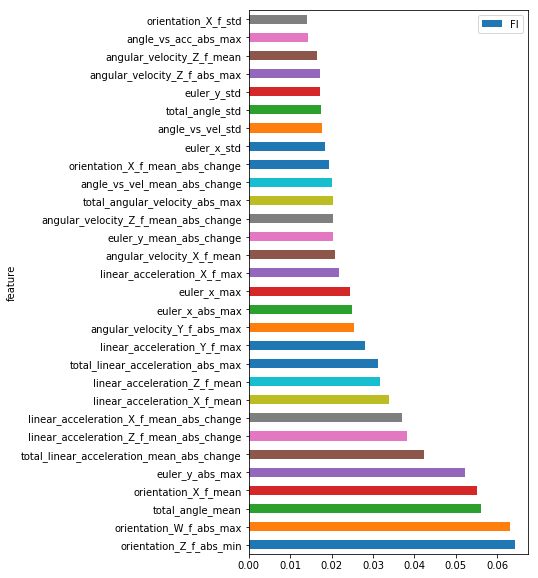

-------------------- 8 -------------------- (3224, 50) (586, 50)
Train score  0.960918114144
Test score  0.563139931741


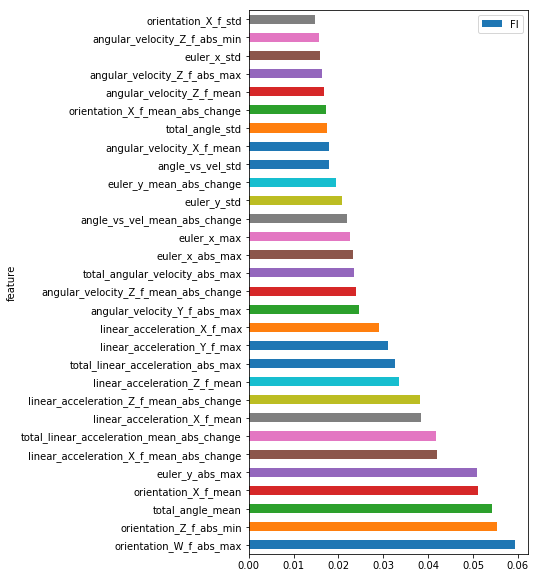

-------------------- 9 -------------------- (3278, 50) (532, 50)
Train score  0.956985967053
Test score  0.434210526316


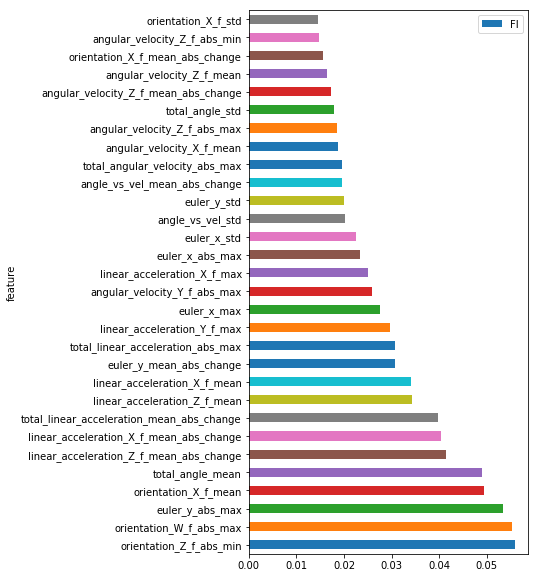

Test Accuracy ['0.74', '0.63', '0.41', '0.54', '0.60', '0.61', '0.60', '0.57', '0.56', '0.43']
F-1 score ['0.74', '0.59', '0.38', '0.51', '0.56', '0.59', '0.57', '0.54', '0.53', '0.39']
Min Accuracy/F-1: 0.41 0.38


/Users/yasinkhatami/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [59]:
clf, FI, y_test, y_pred, score = run_RandomForest_CV(df[select_cols+['group_id', 'series_id', 'surface']], test_stats, cv=10)

In [32]:
np.average(score)

0.54462153527391788

Performance seems to have improved after feature elimination. We can run feature elimination 1 more time and see if we get better results. I'll skip that today.

# StratifiedKFold

With the selected features, we run a StratifiedKFold on "surface" to train and generate output. This one will not be split on group_id, only on surface.

-------------------- 0 --------------------
Train score  0.990801576873
Test score  0.798955613577


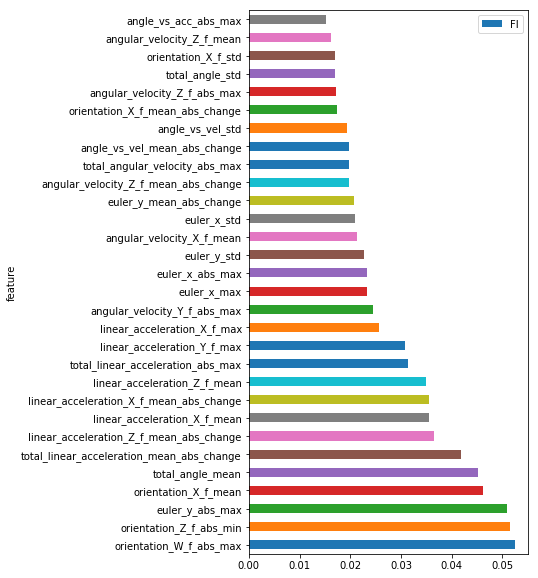

-------------------- 1 --------------------
Train score  0.989490968801
Test score  0.796078431373


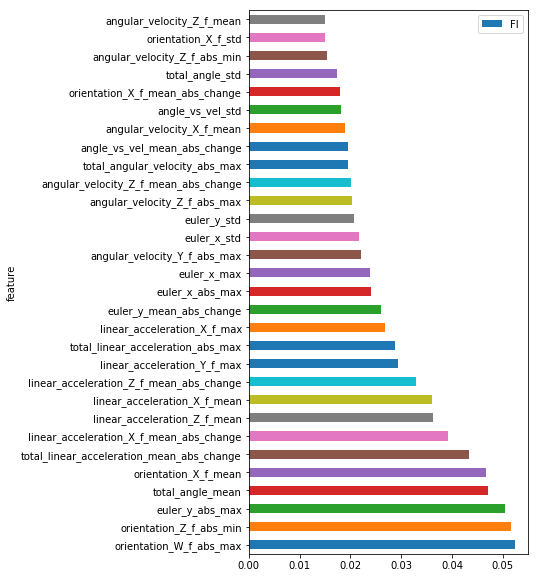

-------------------- 2 --------------------
Train score  0.990157480315
Test score  0.801837270341


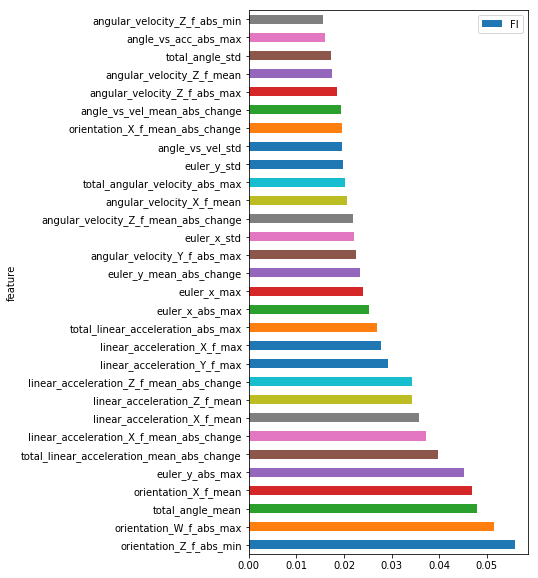

-------------------- 3 --------------------
Train score  0.991475409836
Test score  0.775


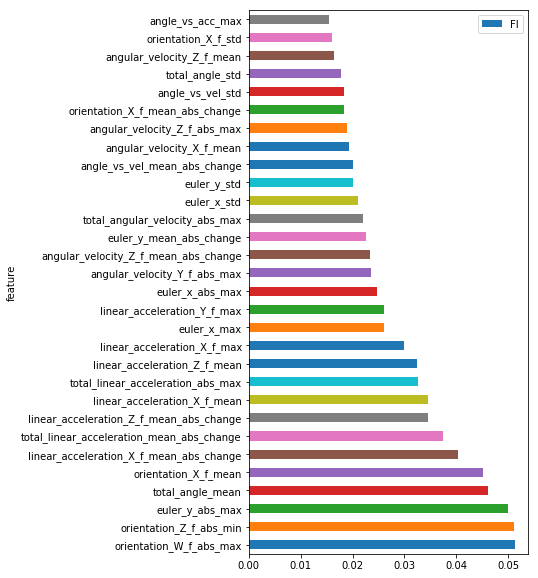

-------------------- 4 --------------------
Train score  0.98788077301
Test score  0.799207397622


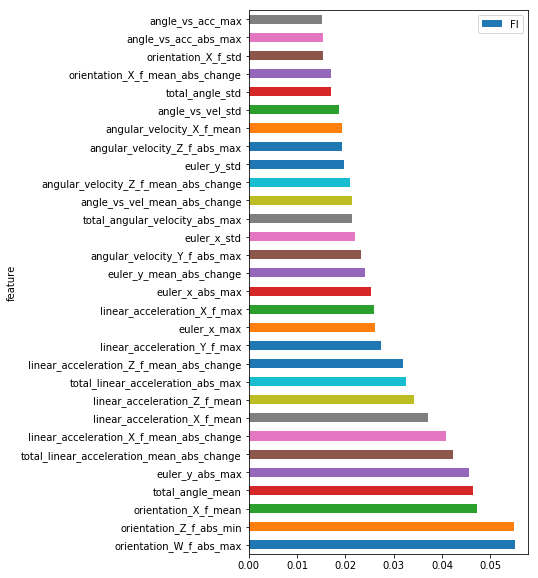

Avg Accuracy 0.794215742583


In [60]:
tr = df[select_cols]
te = test_stats[select_cols]
target = df[['surface', 'group_id']]

# Taken from https://www.kaggle.com/prashantkikani/help-humanity-by-helping-robots

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=546789)
sub_preds_rf = np.zeros((te.shape[0], 9))
oof_preds_rf = np.zeros((tr.shape[0]))
score = 0
clf =  RandomForestClassifier(n_estimators = 400, n_jobs = -1, class_weight="balanced_subsample", max_depth=12)
for i, (train_index, test_index) in enumerate(folds.split(tr, target['surface'])):
    print('-'*20, i, '-'*20)

    clf.fit(tr.iloc[train_index], target['surface'][train_index])
    oof_preds_rf[test_index] = clf.predict(tr.iloc[test_index])
    sub_preds_rf += clf.predict_proba(te) / folds.n_splits
    score += clf.score(tr.iloc[test_index], target['surface'][test_index])
    print('Train score ', clf.score(tr.iloc[train_index], target['surface'][train_index]))
    print('Test score ' , clf.score(tr.iloc[test_index], target['surface'][test_index]))
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    features = tr.columns

    FI = pd.DataFrame([x for x in zip(clf.feature_importances_, features)], columns=['FI', 'feature'])
    FI.sort_values(by='FI', ascending=False).iloc[0:30].plot.barh(x='feature', y='FI', figsize=(5,10))
    plt.show()

print('Avg Accuracy', score / folds.n_splits)

In [61]:
ss['surface'] = le.inverse_transform(sub_preds_rf.argmax(axis=1))
ss.to_csv('submission.csv', index=False)
ss.head(10)

,series_id,surface
0,0,hard_tiles_large_space
1,1,soft_pvc
2,2,tiled
3,3,carpet
4,4,soft_tiles
5,5,concrete
6,6,soft_pvc
7,7,hard_tiles_large_space
8,8,wood
9,9,wood


## Submission

This algorithm gives a LB score of 0.6 to 0.7.

# After feature elimination

select_cols = ['linear_acceleration_X_f_mean',
 'orientation_Y_f_min',
 'orientation_X_f_min',
 'linear_acceleration_Y_f_abs_max',
 'angular_velocity_Z_f_abs_max',
 'angular_velocity_X_f_abs_min',
 'linear_acceleration_Z_f_abs_max',
 'orientation_Y_f_mean_change_of_abs_change',
 'angular_velocity_X_f_mean',
 'linear_acceleration_X_f_min',
 'angular_velocity_X_f_std',
 'orientation_Z_f_abs_min',
 'orientation_Z_f_max',
 'angular_velocity_X_f_min',
 'angular_velocity_Z_f_abs_min',
 'linear_acceleration_Z_f_mean_change_of_abs_change',
 'angular_velocity_Y_f_std',
 'linear_acceleration_Y_f_std',
 'orientation_W_f_mean_abs_change',
 'angular_velocity_X_f_max',
 'total_angular_velocity_abs_max',
 'orientation_W_f_abs_max',
 'linear_acceleration_Z_f_mean_abs_change',
 'angular_velocity_Y_f_min',
 'angular_velocity_X_f_mean_change_of_abs_change',
 'total_angular_velocity_min',
 'angular_velocity_X_f_mean_abs_change',
 'angular_velocity_Z_f_min']